In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from keras.models import load_model
import tensorflow as tf
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/drowsy_detection/vggRetrain/vgg16Retrain_5epoch')

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/drowsy_detection/train_data/dataset_new/train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="training",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 2221 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/drowsy_detection/train_data/dataset_new/train",
    labels='inferred',
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.1,
    subset="validation",
    seed=1024
)

Found 2467 files belonging to 4 classes.
Using 246 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/drowsy_detection/train_data/dataset_new/test",
    labels="inferred",
    batch_size=32,
    image_size=(256,256),
    validation_split=None,
)


Found 433 files belonging to 4 classes.


In [ ]:
aututune = tf.data.AUTOTUNE
train_ds=train_ds.cache().prefetch(buffer_size=aututune)
val_ds=val_ds.cache().prefetch(buffer_size=aututune)
test_ds=test_ds.cache().prefetch(buffer_size=aututune)


In [ ]:
 # import VGG16 # <-- pre-trained model

In [ ]:
model_vgg16=tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))


58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg16.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
model_vgg16.trainable=False


In [ ]:
inputs= tf.keras.Input(shape=(256,256,3))
#x=data_augmentation(inputs)
x=model_vgg16(inputs,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(16,activation='elu')(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(32,activation='elu')(x)
x=tf.keras.layers.Dropout(0.3)(x)
outputs=tf.keras.layers.Dense(4,activation="softmax")(x)
new_model=tf.keras.Model(inputs,outputs)


In [ ]:
new_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])


In [ ]:
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                544   

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1)
checkpoint =  tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/tmp/checkpoint', save_weights_only=True,
    monitor='val_accuracy', mode='max',save_best_only=True
)
history=new_model.fit(train_ds,validation_data=val_ds,epochs=5,callbacks=[callback,checkpoint])

Epoch 1/5
70/70 [==============================] - 1744s 24s/step - loss: 0.6754 - accuracy: 0.7244 - val_loss: 0.3499 - val_accuracy: 0.8008
Epoch 2/5
70/70 [==============================] - 1673s 24s/step - loss: 0.3176 - accuracy: 0.8802 - val_loss: 0.2131 - val_accuracy: 0.9350
Epoch 3/5
70/70 [==============================] - 1662s 24s/step - loss: 0.2283 - accuracy: 0.9136 - val_loss: 0.1539 - val_accuracy: 0.9553
Epoch 4/5
70/70 [==============================] - 1660s 24s/step - loss: 0.1566 - accuracy: 0.9460 - val_loss: 0.1256 - val_accuracy: 0.9756
Epoch 5/5
70/70 [==============================] - 1665s 24s/step - loss: 0.1201 - accuracy: 0.9586 - val_loss: 0.1020 - val_accuracy: 0.9715


In [ ]:
new_model.save('/content/gdrive/MyDrive/drowsy_detection/vggRetrain/vgg16Retrain_5epoch')

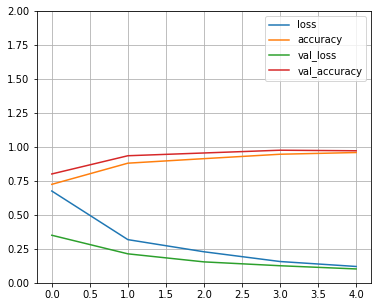

In [ ]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()


In [ ]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)


14/14 [==============================] - 338s 22s/step - loss: 0.1527 - accuracy: 0.9284
0.9284064769744873


In [ ]:
from keras.preprocessing.image import image
import skimage.io as imageio
import cv2
import matplotlib.pyplot as plt
import skimage.io as imageio
import numpy as np
import pandas as pd


In [ ]:
!pip install mtcnn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.0 MB/s 


In [ ]:
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


In [ ]:
pixels = plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg")


Shape of image/array: (480, 640, 3)


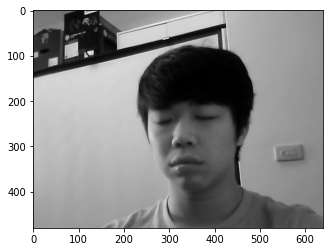

In [ ]:
print("Shape of image/array:",pixels.shape)
imgplot = plt.imshow(pixels)


In [ ]:
detector = mtcnn.MTCNN()

In [ ]:
faces = detector.detect_faces(pixels)

In [ ]:
faces[0]

{'box': [251, 159, 200, 241],
 'confidence': 0.997464656829834,
 'keypoints': {'left_eye': (291, 241),
  'right_eye': (384, 235),
  'nose': (326, 287),
  'mouth_left': (304, 347),
  'mouth_right': (378, 343)}}

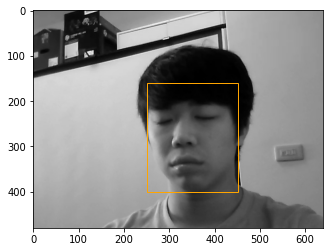

In [ ]:
def draw_facebox(filename, result_list):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = plt.Rectangle((x, y), width, height, fill=False, color='orange')
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()

# filename = 'test1.jpg' # filename is defined above, otherwise uncomment
# load image from file
# pixels = plt.imread(filename) # defined above, otherwise uncomment
# detector is defined above, otherwise uncomment
#detector = mtcnn.MTCNN()
# detect faces in the image
faces = detector.detect_faces(pixels)
# display faces on the original image
draw_facebox('/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg', faces)


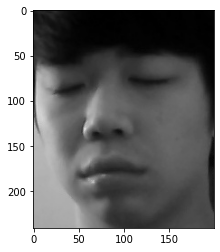

In [ ]:
#left_eye': (291, 241),
import cv2
import matplotlib.pyplot as plt
image=plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg")

#image = cv2.imread('/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg')
x, y, w, h = faces[0]['box']
crop = image[y:y+h, x:x+w]
plt.imshow(crop)


lax,lay = faces[0]['keypoints']['left_eye']

#crop = crop[y:y+lay, x:x+lax]
#plt.imshow(crop)


In [ ]:
from keras.applications.vgg16 import preprocess_input


In [ ]:
from keras.preprocessing.image import image
img = image.load_img('/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg',color_mode='rgb', target_size=(256, 256))


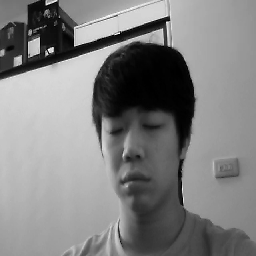

In [ ]:
display(img)

In [ ]:
x = image.img_to_array(img)
x.shape
# Adding the fouth dimension, for number of images
x = np.expand_dims(x, axis=0)

In [ ]:
#mean centering with respect to Image
x = preprocess_input(x)
features = new_model.predict(x)


In [ ]:
features

array([[0.19465584, 0.07084233, 0.5816668 , 0.15283494]], dtype=float32)

In [ ]:
np.argmax(features)

2

In [ ]:
predicted_categories = tf.argmax(features, axis=1)


In [ ]:
predicted_categories

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>

In [ ]:
class_names = {'Closed': 0, 'Open': 1, 'no_yawn': 2, 'yawn': 3}


In [ ]:
reversed_dictionary = dict(map(reversed, class_names.items()))

In [ ]:
reversed_dictionary.get(np.argmax(features))

'no_yawn'

In [ ]:
# Extract only eye region from image - haarcascade
import cv2
eyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_eye.xml")
leyeCascade = cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_lefteye_2splits.xml")
#mouthCascade = cv2.C

In [ ]:
from keras.preprocessing.image import image
img = image.load_img('/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg',color_mode='rgb', target_size=(256, 256))


In [ ]:
detector = mtcnn.MTCNN()

In [ ]:
pixels = plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg")

faces = detector.detect_faces(pixels)

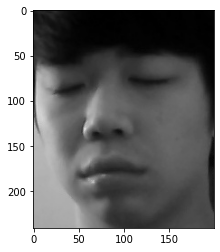

In [ ]:
#left_eye': (291, 241),
import cv2
import matplotlib.pyplot as plt

x, y, w, h = faces[0]['box']
crop = pixels[y:y+h, x:x+w]
plt.imshow(crop)


lax,lay = faces[0]['keypoints']['left_eye']

#crop = crop[y:y+lay, x:x+lax]
#plt.imshow(crop)

In [ ]:
imageCrop = np.expand_dims(crop, axis=0)
imageCrop = preprocess_input(crop)


In [ ]:
geteye=leyeCascade.detectMultiScale(crop,scaleFactor = 1.1, minNeighbors = 4)


In [ ]:
gozler=[]
for (x,y,w,h) in geteye:
    print(type(crop[y:y+h, x:x+w]))
    gozler.append(crop[y:y+h, x:x+w])


<class 'numpy.ndarray'>


In [ ]:
from PIL import Image
import numpy as np

imageOne = Image.fromarray(gozler[0].astype(np.uint8))

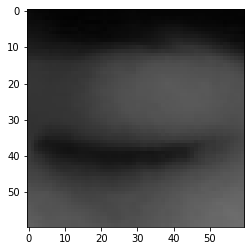

In [ ]:
plt.imshow(imageOne)

In [ ]:
imageEye = np.expand_dims(imageOne, axis=0)
imageEye = preprocess_input(imageEye)


In [ ]:
predictions=new_model.predict(imageEye)

In [ ]:
predictions

array([[9.9992728e-01, 7.7587856e-06, 1.5015622e-06, 6.3459003e-05]],
      dtype=float32)

In [ ]:
reversed_dictionary.get(np.argmax(predictions))

'Closed'

In [ ]:
# Detect for open eyes
pixelsOpenEye = plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame150.jpg")
faces = detector.detect_faces(pixelsOpenEye)

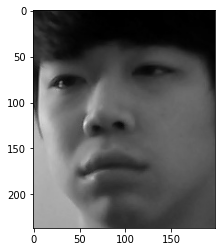

In [ ]:
import cv2
import matplotlib.pyplot as plt
#image=plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg")

#image = cv2.imread('/content/gdrive/MyDrive/drowsy_detection/test_images/frame2260.jpg')
x, y, w, h = faces[0]['box']
cropOpenEye = pixelsOpenEye[y:y+h, x:x+w]
plt.imshow(cropOpenEye)



In [ ]:
imageCrop = np.expand_dims(cropOpenEye, axis=0)
imageCrop = preprocess_input(cropOpenEye)


In [ ]:
geteyeOpen=leyeCascade.detectMultiScale(cropOpenEye,scaleFactor = 1.1, minNeighbors = 4)


In [ ]:
gozler=[]
for (x,y,w,h) in geteyeOpen:
    print(type(cropOpenEye[y:y+h, x:x+w]))
    gozler.append(cropOpenEye[y:y+h, x:x+w])


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
from PIL import Image
import numpy as np

imageOne = Image.fromarray(gozler[0].astype(np.uint8))

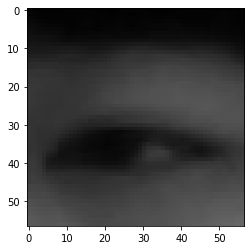

In [ ]:
plt.imshow(imageOne)

In [ ]:
imageEyeOpen = np.expand_dims(imageOne, axis=0)
imageEyeOpen = preprocess_input(imageEyeOpen)


In [ ]:
predictions=new_model.predict(imageEyeOpen)

In [ ]:
predictions

array([[7.9279125e-02, 9.0085232e-01, 7.1603485e-04, 1.9152505e-02]],
      dtype=float32)

In [ ]:
reversed_dictionary.get(np.argmax(predictions))

'Open'

In [ ]:
# Check for yawn
pixelsYawn = plt.imread("/content/gdrive/MyDrive/drowsy_detection/test_images/frame300.jpg")
faces = detector.detect_faces(pixelsYawn)

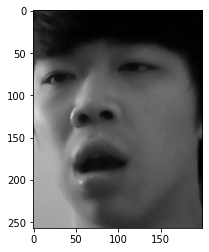

In [ ]:
import cv2
import matplotlib.pyplot as plt
x, y, w, h = faces[0]['box']
cropYawnPerson = pixelsYawn[y:y+h, x:x+w]
plt.imshow(cropYawnPerson)


In [ ]:
imageCropYawn = np.expand_dims(cropYawnPerson, axis=0)
imageCropYawn = preprocess_input(imageCropYawn)


In [ ]:
prediction_yawn = new_model.predict(imageCropYawn)

In [ ]:
prediction_yawn

array([[0.1591844 , 0.72527224, 0.02849311, 0.08705022]], dtype=float32)

In [ ]:
reversed_dictionary.get(np.argmax(prediction_yawn))

'Open'

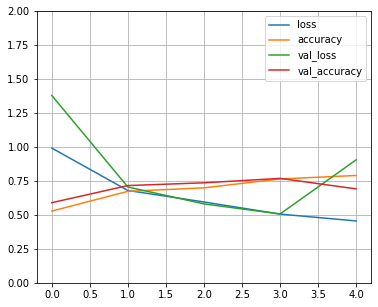

In [ ]:
pd.DataFrame(history.history).plot(figsize=(6,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

In [ ]:
loss_t, acc_t= new_model.evaluate(test_ds)
print(acc_t)

14/14 [==============================] - 171s 6s/step - loss: 1.0357 - accuracy: 0.6467
0.6466512680053711
